### 1. Импорты

In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

# Настройки для отображения графиков
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

### 2. Извлечение данных из файлов

In [62]:
# Загрузка данных
PATH = "data"
FILETEST = os.path.join(PATH, "test.csv")    
FILETRAIN = os.path.join(PATH, "train.csv") 

df_test = pd.read_csv(FILETEST)
df_train = pd.read_csv(FILETRAIN)
df_test_original = df_test.copy()

print("Информация о данных:")
print(f"Размер обучающих данных: {df_train.shape}")
print(f"Размер тестовых данных: {df_test.shape}")

df_test.info()

Информация о данных:
Размер обучающих данных: (1460, 81)
Размер тестовых данных: (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  Hous

Что бросается в глаза сразу же:
1. **`Id`**. Его можно удалить, так как в `pandas` они автоматически создаются.
2. **`MSSubClass`** переменная числовая, хотя возможно стоит разделить на несколько столбцов object, которые будут более детально отображать данные о постройке. Можно разделить на следующие столбцы: 
    - сколько этажей 
    - является ли постройка **1946 Г. И НОВЕЕ** или **1945 Г. И СТАРШЕ**, есть точный показатель в **`YearBuilt`**. Так же есть и **`YearRemodAdd`** - год реконструкции.
    - стиль постройки, который также есть в параметрах **`BldgType`** (Тип жилья) и **`HouseStyle`** (Стиль жилья) 
3. **`LotFrontage`** указана не везде
4. **`Alley`** мало значений, видимо значение `NA` (Нет переулка/аллеи) автоматически приводится к `NuN`
5. **`Utilities`** стоит немного преобразовать. Создать столбцы: газ, вода, электричество, канализация.
6. **`LandSlope`** стоит обозначить цифрами например:
    *   `Gtl`: Пологий уклон 1
    *   `Mod`: Умеренный уклон 2
    *   `Sev`: Крутой уклон 3
7. **`Condition1`** и **`Condition2`** явно надо преобразовывать. Что тут можно выделить с первого взгляда:
    * видно, что тут тоже указывается наличие поблизости парка или зеленой зоны, как и в **`MSZoning`**.
    * есть такие категории как:
        *   `RRNe`: В пределах 200 футов от железной дороги Восток-Запад
        *   `RRAe`: Рядом с железной дорогой Восток-Запад
        *   `RRNn`: В пределах 200 футов от железной дороги Север-Юг
        *   `RRAn`: Рядом с железной дорогой Север-Юг.
        ---
        их думаю стоит объедининь в 1 столбец. указывать 0 - нет жд по близости, 1 - в пределах 200 футов жд, 2 - рядом жд.
        Tак же поступить с:
        *   `Artery`: Рядом с магистральной улицей
        *   `Feedr`: Рядом с второстепенной улицей (подъездной)
        ---
        Создать также столбец наличия парка или зеленой зоны по близости.
        
8. **`YearBuilt`** **`YearRemodAdd`**, **`GarageYrBlt`**. думаю стоит нормализовать данные признаки для удобства работы с ними модели. Можно найти самый поздний год и вычитать из него остальные значения.
9. **`Exterior1st`** и **`Exterior2nd`** стоит изучить более детально. 
10. **`MasVnrType`** и **`MasVnrArea`** имеют отсутствующие значения. странно что **`MasVnrType`** гораздо меньше чем **`MasVnrArea`**
11. **`ExterQual`** и **`ExterCond`**, **`HeatingQC`**, **`KitchenQual`**, **`GarageQual`**, **`GarageCond`**, оценки стоит перевести в числа
12. **`BsmtQual`** думаю тоже стоит перевести в числовой формат обозначить от 5 (отлично) до 0 (нет подвала). так же **`BsmtCond`** и **`BsmtExposure`**
13. Непонятно чем **`BsmtFinType1`** отличается от **`BsmtFinType2`**. Если это части подвала, то можно их так же по цифрам оценки обозначать. Также есть категории **`BsmtFinSF1`**, **`BsmtFinSF2`**, **`BsmtUnfSF`** и **`TotalBsmtSF`**. Если **`TotalBsmtSF`** равняется сумме площадей разных типов (что надо проверить), то необходимость данного столбца отпадает. И непонятно почему где-то значение 1422 а где-то 1423. Нужно изучить этот один случай.
14. **`CentralAir`** - категории да и нет стоит перевести в 1 и 0.
15. **`Electrical`** - возможно тоже стоит перевести в оценки или разбить на другие категории. Интересно что у одного значение отсутствует. Возможно это стоит считать как отсутствие электропроводки.
16. **`Functional`**, **`FireplaceQu`**, **`GarageFinish`**, **`PavedDrive`** - перевести в числовой формат
17. **`PoolQC`**, **`Fence`** - перевести в числа
18. **`MiscFeature`** - интересный столбец который содержит некоторую полезную информацию. Думаю стоит создать столбец количество гаражей, и наличие категорий которые тут присутствуют.
19. **`MoSold`** и **`YrSold`** стоит обрабатывать в совокупности. думаю стоит опять же найти самую позднюю дату и вычитать из нее количество месяцев.
20. **`SaleType`** так же содержит интересную информацию например 
    *   `Con`: Контракт с 15% первоначальным взносом, обычные условия
    *   `ConLw`: Контракт с низким первоначальным взносом и низкой процентной ставкой
    *   `ConLI`: Контракт с низкой процентной ставкой
    *   `ConLD`: Контракт с низким первоначальным взносом
    ---
    данные столбы следует преобразовать в 2 столбца. 
    *   `WD`: Гарантийный акт (Warranty Deed) - Обычная продажа
    *   `CWD`: Гарантийный акт - Продажа за наличные
    *   `VWD`: Гарантийный акт - Заем для ветеранов (VA Loan)
    ---
    тоже переработать в другие столбцы
    *   `New`: Только что построенный и проданный дом - не несет в себе новой информации. Остальные категории думаю оставить.

*Думаю сначала попробовать обучить модель на данных как есть, потом постепенно изменять таблицу и оценивать то или иное изменение.*

### 3. Обработка пропущенных значений

In [63]:
# Заполнение пропущенных числовых значений нулями
numeric_columns_to_fill = [
    'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
    'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 
    'GarageCars', 'GarageArea', 
]

for col in numeric_columns_to_fill:
    if col in df_train.columns:
        df_train[col].fillna(0, inplace=True)
    if col in df_test.columns:
        df_test[col].fillna(0, inplace=True)



### 4. Подготовка данных для обучения

In [64]:
# Создание копий для обработки
df_train_processed = df_train.copy()
df_test_processed = df_test.copy()

# Удаление ненужных столбцов
df_train.drop('Id', axis=1, inplace=True, errors='ignore')
df_test.drop('Id', axis=1, inplace=True, errors='ignore')

#### 4.1 Подготовка данных для обучения без оптимизации.
Данный способ показал результат на kaggle ~1.2. Однако обучение проходит достаточно непредсказуемо. Результаты разных обучений сильно варьируются. Один из `submission` показал результат 0.473 на kaggle, однако повторить данный результат даже просто лучше 1.0 не удалось. Из этого можно сделать предположение, что существуют столбцы с мусорной информацией, которые не дают модели обучиться до хорошего качества. По видимому из-за этого модель логистической регрессии показывала еще худший результат чем простая модель с 2 слоями. 
* 243 признака у данных.

In [65]:
# df_train_processed.drop('GarageYrBlt', axis=1, inplace=True, errors='ignore')
# df_test_processed.drop('GarageYrBlt', axis=1, inplace=True, errors='ignore')
# # # Определение категориальных признаков
# categorical_features = [
#     'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
#     'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
#     'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
#     'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 
#     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
#     'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 
#     'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
#     'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
#     'SaleType', 'SaleCondition'
# ]

#### 4.2 Подготовка минимально оптимизированных данных для обучения.
Здесь попробуем все столбцы оценки перевести в числовой формат, и посмотрим как это скажется на качестве. Так же удалил бесполезный первый столбец. 
Итоги:
* Здесь добились качественного улучшения обучения модели. точность на kaggle улучшилась с ~1,2 до ~0,52
* Количество параметров уменьшилось с 243 до 212
* Процесс обучения стал чуть стабильнее, но все еще не достаточно.

In [66]:
# Удаляем год построики гаража, так как неизвестно как обрабатывать 
df_train_processed.drop('GarageYrBlt', axis=1, inplace=True, errors='ignore')
df_test_processed.drop('GarageYrBlt', axis=1, inplace=True, errors='ignore')

# 1. Пятибальные шкалы
five_point_scales = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
names_of_grades = ['Ex', 'Gd', 'TA', 'Fa', 'Po'] 
numerical_grades = [5, 4, 3, 2, 1]

# Создаем словарь для замены
# {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
grade_to_numerical_map = dict(zip(names_of_grades, numerical_grades))

for column in five_point_scales:
    # Сначала заменяем строковые значения на числовые
    df_train_processed[column] = df_train_processed[column].replace(grade_to_numerical_map)
    df_test_processed[column] = df_test_processed[column].replace(grade_to_numerical_map)
    # Затем заменяем все NaN на 0
    df_train_processed[column] = df_train_processed[column].fillna(0).astype(int)
    df_test_processed[column] = df_test_processed[column].fillna(0).astype(int)

# 2. Обработка других шкал и категорий оценки
# Оценка освещенности подвала. Нет освещенности и нет подвала будет 0
names_of_grades = ['Gd', 'Av', 'Mn', 'No'] 
numerical_grades = [3, 2, 1, 0]
grade_to_numerical_map = dict(zip(names_of_grades, numerical_grades))
df_train_processed['BsmtExposure'] = df_train_processed['BsmtExposure'].replace(grade_to_numerical_map)
df_train_processed['BsmtExposure'] = df_train_processed['BsmtExposure'].fillna(0).astype(int)
df_test_processed['BsmtExposure'] = df_test_processed['BsmtExposure'].replace(grade_to_numerical_map)
df_test_processed['BsmtExposure'] = df_test_processed['BsmtExposure'].fillna(0).astype(int)

# Функциональность дома
names_of_grades = ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'] 
numerical_grades = [0, 1, 2, 3, 4, 5, 6, 7]
grade_to_numerical_map = dict(zip(names_of_grades, numerical_grades))
df_train_processed['Functional'] = df_train_processed['Functional'].replace(grade_to_numerical_map)
df_train_processed['Functional'] = df_train_processed['Functional'].fillna(0).astype(int)
df_test_processed['Functional'] = df_test_processed['Functional'].replace(grade_to_numerical_map)
df_test_processed['Functional'] = df_test_processed['Functional'].fillna(0).astype(int)

# Так же удалим бесполезный столбец MSSubClass
df_train.drop('MSSubClass', axis=1, inplace=True, errors='ignore')
df_test.drop('MSSubClass', axis=1, inplace=True, errors='ignore')


# Определение категориальных признаков
# categorical_features = [
#     'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
#     'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
#     'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
#     'Exterior2nd', 'MasVnrType',   'Foundation', 'BsmtFinType1', 'BsmtFinType2', 
#     'Heating', 'CentralAir', 'Electrical', 'GarageType', 'GarageFinish',  
#     'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'
# ]


#### 4.3 Подготовка хорошо оптимизированной таблицы.
Выполняется весь предыдущий код кроме определения категориальных признаков
Итоги:
* Улучшили показатель на kaggle c ~0,52 до 0,43
* Уменьшили количество параметров с 212 до 208


In [67]:
# Переведем в числа все столбцы где категориии можно четко отсортировать
name_col = 'LotShape'
names_of_grades = ['Reg', 'IR1', 'IR2', 'IR3'] 
numerical_grades = [0, 1, 2, 3]
grade_to_numerical_map = dict(zip(names_of_grades, numerical_grades))
df_train_processed[name_col] = df_train_processed[name_col].replace(grade_to_numerical_map)
df_train_processed[name_col] = df_train_processed[name_col].fillna(0).astype(int)
df_test_processed[name_col] = df_test_processed[name_col].replace(grade_to_numerical_map)
df_test_processed[name_col] = df_test_processed[name_col].fillna(0).astype(int)

name_col = 'LandSlope'
names_of_grades = ['Gtl', 'Mod', 'Sev'] 
numerical_grades = [0, 1, 2]
grade_to_numerical_map = dict(zip(names_of_grades, numerical_grades))
df_train_processed[name_col] = df_train_processed[name_col].replace(grade_to_numerical_map)
df_train_processed[name_col] = df_train_processed[name_col].fillna(0).astype(int)
df_test_processed[name_col] = df_test_processed[name_col].replace(grade_to_numerical_map)
df_test_processed[name_col] = df_test_processed[name_col].fillna(0).astype(int)

name_col = 'GarageFinish'
names_of_grades = ['Unf', 'RFn', 'Fin'] 
numerical_grades = [1, 2, 3]
grade_to_numerical_map = dict(zip(names_of_grades, numerical_grades))
df_train_processed[name_col] = df_train_processed[name_col].replace(grade_to_numerical_map)
df_train_processed[name_col] = df_train_processed[name_col].fillna(0).astype(int)
df_test_processed[name_col] = df_test_processed[name_col].replace(grade_to_numerical_map)
df_test_processed[name_col] = df_test_processed[name_col].fillna(0).astype(int)

name_col = 'PavedDrive'
names_of_grades = ['N', 'P', 'Y'] 
numerical_grades = [0, 1, 2]
grade_to_numerical_map = dict(zip(names_of_grades, numerical_grades))
df_train_processed[name_col] = df_train_processed[name_col].replace(grade_to_numerical_map)
df_train_processed[name_col] = df_train_processed[name_col].fillna(0).astype(int)
df_test_processed[name_col] = df_test_processed[name_col].replace(grade_to_numerical_map)
df_test_processed[name_col] = df_test_processed[name_col].fillna(0).astype(int)

# Также нормализуем все года (кроме постройки гаража, так как все еще не понятно как обрабатывать NuN значения)
year_colums = ['YearBuilt', 'YearRemodAdd']
df_train_processed[year_colums] = 2011 - df_train_processed[year_colums]
df_test_processed[year_colums] = 2011 - df_test_processed[year_colums]

df_train_processed['MoSold'] = 12 - df_train_processed['MoSold'] + (2010 - df_train_processed['YrSold']) * 12
df_test_processed['MoSold'] = 12 - df_test_processed['MoSold'] + (2010 - df_test_processed['YrSold']) * 12

df_train.drop('YrSold', axis=1, inplace=True, errors='ignore')
df_test.drop('YrSold', axis=1, inplace=True, errors='ignore')

# Определение категориальных признаков
categorical_features = [
    'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 
    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
    'Exterior2nd', 'MasVnrType',   'Foundation', 'BsmtFinType1', 'BsmtFinType2', 
    'Heating', 'CentralAir', 'Electrical', 'GarageType',  
    'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'
]

### 5. Разделение на признаки и целевую переменную и обработка категориальных признаков

In [68]:
#------Обработка категориальных признаков----------

print(f"\nРазмер до One-Hot Encoding:")
print(f"Train: {df_train_processed.shape}, Test: {df_test_processed.shape}")

# One-Hot Encoding для категориальных признаков
df_train_processed = pd.get_dummies(
    df_train_processed, 
    columns=categorical_features, 
    drop_first=True, 
    dtype=int
)
df_test_processed = pd.get_dummies(
    df_test_processed, 
    columns=categorical_features, 
    drop_first=True, 
    dtype=int
)

# Выравнивание столбцов между train и test
target = 'SalePrice'
train_cols = df_train_processed.drop(target, axis=1, errors='ignore').columns.tolist()
test_cols = df_test_processed.columns.tolist()
print(test_cols)
# Добавление отсутствующих столбцов в test
for col in train_cols:
    if col not in test_cols:
        df_test_processed[col] = 0

# Удаление лишних столбцов из test
for col in test_cols:
    if col not in train_cols:
        print(f"Удаляем столбец '{col}' из test набора")
        df_test_processed.drop(col, axis=1, inplace=True)

print(f"\nРазмер после обработки:")
print(f"Train: {df_train_processed.shape}, Test: {df_test_processed.shape}")

# Проверка на пропущенные значения
print("\nПроверка на NaN в test данных:")
nan_columns_test = df_test_processed.isnull().sum()
print(nan_columns_test[nan_columns_test > 0])

#---Разделение на признаки и целевую переменную---

X = df_train_processed.drop(target, axis=1)
y = df_train_processed[target]
X_test_final = df_test_processed.copy()

# Логарифмирование целевой переменной для лучшей работы модели
y_log = np.log1p(y) 

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X, y_log, 
    test_size=0.2, 
    random_state=42, 
)

print(f"\nРазделение данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train_log.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val_log.shape}")


Размер до One-Hot Encoding:
Train: (1460, 80), Test: (1459, 79)
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_Pave', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neigh

### 6. Преобразование в pytorch тензоры

In [69]:
# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val_log.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_final.values, dtype=torch.float32)

print("\nДанные преобразованы в тензоры PyTorch")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")


Данные преобразованы в тензоры PyTorch
X_train_tensor: torch.Size([1168, 208])
y_train_tensor: torch.Size([1168, 1])


### 7. Создание Dataset и DataLoader

In [70]:
class HousesDataset(Dataset):
    """Класс для работы с данными о домах"""
    
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels
        self.is_test = labels is None
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        item_features = self.features[idx]
        if self.is_test:
            return item_features
        else:
            item_labels = self.labels[idx]
            return item_features, item_labels

# Создание datasets
train_dataset = HousesDataset(X_train_tensor, y_train_tensor)
val_dataset = HousesDataset(X_val_tensor, y_val_tensor)
test_dataset = HousesDataset(X_test_tensor)

# Создание dataloaders
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader'ы созданы с размером батча: {BATCH_SIZE}")


DataLoader'ы созданы с размером батча: 128


### 8. Определение модели

In [71]:
class DeepRegressionModel(nn.Module):
    """Глубокая нейронная сеть для регрессии"""
    
    def __init__(self, num_input_features, num_output_features):
        super(DeepRegressionModel, self).__init__()
        
        self.bn1 = nn.BatchNorm1d(num_input_features)
        self.fc1 = nn.Linear(num_input_features, 128)
        self.relu1 = nn.GELU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.GELU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.bn3 = nn.BatchNorm1d(64)
        self.output_layer = nn.Linear(64, num_output_features)

    def forward(self, x):
        x = self.bn1(x)
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        
        x = self.bn2(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.bn3(x)
        x = self.output_layer(x)
        return x

# Создание модели
input_features = X_train_tensor.shape[1]
output_units = 1
model = DeepRegressionModel(input_features, output_units)

print("\nАрхитектура модели:")
print(model)



Архитектура модели:
DeepRegressionModel(
  (bn1): BatchNorm1d(208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=208, out_features=128, bias=True)
  (relu1): GELU(approximate='none')
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): GELU(approximate='none')
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


### 9. Настройка обучения

In [72]:
# Функция потерь и оптимизатор
criterion = nn.MSELoss()
learning_rate = 0.004
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Планировщик скорости обучения
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=40)

print("\nНастройка обучения:")
print(f"Функция потерь: MSE")
print(f"Оптимизатор: RAdam")
print(f"Learning rate: {learning_rate}")


Настройка обучения:
Функция потерь: MSE
Оптимизатор: RAdam
Learning rate: 0.004


### 10. Цикл обучения

In [73]:
# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nОбучение будет производиться на: {device}")
model.to(device)

# Гиперпараметры
num_epochs = 260
train_losses = []
val_losses = []

print(f"\nНачинаем обучение на {num_epochs} эпох...")

for epoch in range(num_epochs):
    # Фаза обучения
    model.train()
    current_epoch_train_loss = 0.0
    
    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_epoch_train_loss += loss.item() * features.size(0)
    
    epoch_train_loss = current_epoch_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Фаза валидации
    model.eval()
    current_epoch_val_loss = 0.0
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            current_epoch_val_loss += loss.item() * features.size(0)
    
    epoch_val_loss = current_epoch_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Обновление планировщика
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Вывод результатов эпохи
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {epoch_train_loss:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")
        print("-" * 50)

print("\nОбучение завершено!")



Обучение будет производиться на: cuda

Начинаем обучение на 260 эпох...
Эпоха [1/260]:
  Train Loss: 135.5048
  Val Loss: 158.0522
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [20/260]:
  Train Loss: 51.7063
  Val Loss: 46.4227
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [40/260]:
  Train Loss: 1.5461
  Val Loss: 0.4491
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [60/260]:
  Train Loss: 0.8174
  Val Loss: 0.1912
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [80/260]:
  Train Loss: 0.5356
  Val Loss: 0.0444
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [100/260]:
  Train Loss: 0.2916
  Val Loss: 0.0328
  Learning Rate: 0.004000
--------------------------------------------------
Эпоха [120/260]:
  Train Loss: 0.1494
  Val Loss: 0.0309
  Learning Rate: 0.004000
----------------------------------------

### 11. Визуализация результатов

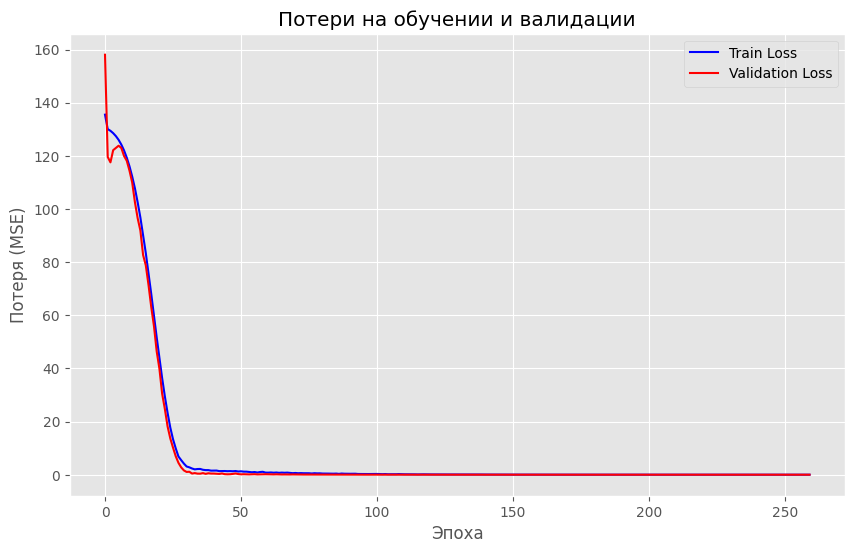

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Эпоха')
plt.ylabel('Потеря (MSE)')
plt.legend()
plt.title('Потери на обучении и валидации')
plt.grid(True)
plt.show()


### 12. Создание submission файла

In [75]:
# Генерация предсказаний
model.eval()
all_predictions = []

with torch.no_grad():
    for features_batch in test_loader:
        features_batch = features_batch.to(device)
        outputs = model(features_batch)
        # Преобразование обратно из логарифмического масштаба
        predicted_prices = torch.expm1(outputs)
        all_predictions.extend(predicted_prices.cpu().numpy().flatten().tolist())

print(f"\nПредсказания для {len(all_predictions)} тестовых примеров сгенерированы.")

# Создание submission файла
if 'Id' in df_test_original.columns:
    if len(df_test_original) == len(all_predictions):
        submission_df = pd.DataFrame({
            'Id': df_test_original['Id'],
            'SalePrice': all_predictions
        })
        
        submission_filename = 'submission_house_prices.csv'
        submission_df.to_csv(submission_filename, index=False)
        
        print(f"\nSubmission файл '{submission_filename}' успешно создан.")
        print("Первые 5 строк submission файла:")
        print(submission_df.head())
        
        print(f"\nСтатистика предсказаний:")
        print(f"Средняя цена: ${np.mean(all_predictions):,.2f}")
        print(f"Минимальная цена: ${np.min(all_predictions):,.2f}")
        print(f"Максимальная цена: ${np.max(all_predictions):,.2f}")
    else:
        print(f"\nОшибка: Несовпадение количества предсказаний ({len(all_predictions)}) "
              f"и строк в исходных данных ({len(df_test_original)})")
else:
    print("\nОшибка: Столбец 'Id' не найден в исходных данных")

print(f"\nФинальная потеря на валидации: {val_losses[-1]:.4f}")
print("Анализ завершен!")


Предсказания для 1459 тестовых примеров сгенерированы.

Submission файл 'submission_house_prices.csv' успешно создан.
Первые 5 строк submission файла:
     Id      SalePrice
0  1461  133317.609375
1  1462   89517.000000
2  1463  142476.250000
3  1464  137719.437500
4  1465  121768.781250

Статистика предсказаний:
Средняя цена: $127,119.77
Минимальная цена: $39,291.16
Максимальная цена: $648,591.38

Финальная потеря на валидации: 0.0202
Анализ завершен!
